In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q opendatasets

import opendatasets as od
od.download('https://www.kaggle.com/datasets/seoyunje/colonoscopy-256x256-resized-png')
od.download('https://www.kaggle.com/datasets/msyu78/metadataset')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: msyu78
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/seoyunje/colonoscopy-256x256-resized-png


100%|██████████| 190M/190M [00:00<00:00, 265MB/s]



Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: msyu78
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/msyu78/metadataset


100%|██████████| 657k/657k [00:00<00:00, 50.8MB/s]

## 1. Import Library
___

**Install EfficientDet Library**

In [3]:
!pip install -q git+https://github.com/rwightman/efficientdet-pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

**Install tf-efficientnet Library**

In [4]:
!pip install -q efficientnet

from efficientnet.keras import preprocess_input

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.5 MB/s eta 0:00:00


In [5]:
!pip install -q colorama

In [6]:
import os
import sys
import pickle
import random
import gc
import ctypes
import copy
from collections import defaultdict

from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from colorama import Fore
from PIL import Image
import cv2

import torch; import timm
print(f'{Fore.BLUE} => Pytorch Version: ', torch.__version__)
print(f'{Fore.BLUE} => Timm Version: ', timm.__version__)
import torch.nn as nn
from torch.cuda import amp
import torch.functional as F
from torch.utils.data import DataLoader, Dataset

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

## EfficientDet Library
from effdet.efficientdet import EfficientDet, HeadNet, BiFpn
from effdet.bench import DetBenchTrain, DetBenchPredict
# default config: tf_efficientdet_d1
from effdet.config import get_efficientdet_config, default_detection_model_configs
from effdet.config import default_detection_train_config, get_fpn_config

from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
import warnings
warnings.filterwarnings('ignore')

print(f'{Fore.BLUE} => Installed Necessary Library')

 => Pytorch Version:  2.5.1+cu124
 => Timm Version:  1.0.15


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


 => Installed Necessary Library


### Configuration

In [7]:
class CFG:
    output_dir = 'runs/predict'
    seed = 2025

    img_size = [256, 256]
    imgdir = '/content/drive/MyDrive/Endoscope Detection/colonoscopy/EfficientDet'
    model_name = 'resdet50'
    pretrained_model = '/content/drive/MyDrive/Endoscope Detection/colonoscopy/EfficientDet/experiment2/best-checkpoint.bin'
    num_classes = 3 # Ulcer, Polyp, Cancer
    batch_size = 32

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    device_count = torch.cuda.device_count()

print('Device is', CFG.device)
print('Num GPU of machine is', CFG.device_count)

Device is cuda
Num GPU of machine is 1


### Reproducibility

In [8]:
def seed_everything(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    os.environ['PYTHONHASHSEED'] = str(seed)

seed_everything(CFG.seed)

### Clean_memory

In [9]:
def clean_memory():
    ctypes.CDLL('libc.so.6').malloc_trim(0)
    gc.collect()

clean_memory()

## 2. Build Dataset
___

In [10]:
df = pd.read_csv('/content/drive/MyDrive/Endoscope Detection/colonoscopy/colonoscopy_data.csv')
print('Shape of DataFrame: ', df.shape)
print(display(df))

Shape of DataFrame:  (2496, 14)


,image_id,height,width,organ,lesion_label,location,shape_type_polygon,polygon_mask,bounding_box_shape,x_min,y_min,x_max,y_max,lesion
0,2_1_00001.png,2048,2048,colonoscopy,0,1,polygon,"1484.52,775.16;1516.82,710.56;1519.30,640.99;1...",rectangle,838.559006,149.068323,1519.304348,807.453416,ulcer
1,2_1_00001.png,2048,2048,colonoscopy,0,1,polygon,"1663.40,1478.26;1653.47,1426.09;1616.20,1388.8...",rectangle,1310.608696,1324.223602,1663.403727,1868.322981,ulcer
2,2_1_00002.png,2048,2048,colonoscopy,0,1,polygon,"687.01,223.60;687.01,273.29;704.40,337.89;726....",rectangle,687.006211,168.944099,1591.354037,1465.838509,ulcer
3,2_1_00002.png,2048,2048,colonoscopy,0,1,polygon,"826.14,1200.00;878.31,1207.45;932.97,1187.58;9...",rectangle,488.248447,434.782609,1007.503106,1207.453416,ulcer
4,2_1_00002.png,2048,2048,colonoscopy,0,1,polygon,"575.20,1038.51;520.55,1050.93;468.37,1050.93;4...",rectangle,212.472050,725.465839,607.503106,1050.931677,ulcer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2491,2_2_05111.png,2048,2048,colonoscopy,1,1,polygon,"1113.11,963.83;1070.55,976.60;1032.26,995.74;1...",rectangle,898.212766,948.936170,1493.957447,1527.659574,polyp
2492,2_2_05112.png,2048,2048,colonoscopy,1,1,polygon,"1230.13,1397.87;1187.57,1408.51;1138.64,1425.5...",rectangle,866.297872,1370.212766,1821.617021,1889.361702,polyp
2493,2_2_05113.png,2048,2048,colonoscopy,1,1,polygon,"1021.62,642.55;979.06,653.19;938.64,668.09;898...",rectangle,810.978723,642.553192,1268.425532,1038.297872,polyp
2494,2_2_05114.png,2048,2048,colonoscopy,1,1,polygon,"883.32,972.34;845.02,997.87;806.72,1025.53;776...",rectangle,772.680851,970.212766,1121.617021,1223.404255,polyp


None


In [11]:
df['lesion_label'] = df['lesion_label'] + 1

In [12]:
test_id = [x.split('/')[-1] for x in glob('/content/drive/MyDrive/Endoscope Detection/colonoscopy/EfficientDet/test/*.png')]

test_df = df[df['image_id'].isin(test_id)].reset_index(drop=True)

print('=> Number of Unique Image_id in Test: ', test_df.image_id.nunique())

=> Number of Unique Image_id in Test:  400


In [13]:
class Test_GastroscopyDataset(Dataset):
    def __init__(self, df, image_dir=None):
        super(Test_GastroscopyDataset).__init__()
        self.image_ids = df['image_id'].unique()
        self.df = df
        self.image_dir = image_dir

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, index):
        image_id = self.image_ids[index]
        path = os.path.join(f'{self.image_dir}', 'test', image_id)
        image = Image.open(path).resize((CFG.img_size[0],CFG.img_size[1]))
        image = np.array(image)

        ## FillNan
        m = np.nanmean(image)
        image = np.nan_to_num(image, nan=m)

        image = preprocess_input(image)
        image = torch.tensor(image.transpose(2,0,1).astype(np.float32))

        return image, image_id


In [14]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [15]:
test_dataset = Test_GastroscopyDataset(
    df = test_df,
    image_dir = CFG.imgdir
)

test_loader = DataLoader(
    test_dataset,
    batch_size = CFG.batch_size,
    shuffle = False,
    collate_fn = collate_fn
)

## 3. Inference
___

In [16]:
def load_net(checkpoint_path):
    config = get_efficientdet_config(model_name=CFG.model_name)
    config.num_classes = CFG.num_classes
    config.image_size = CFG.img_size
    config.max_det_per_image = 100

    net = EfficientDet(config, pretrained_backbone=False)
    net.box_net = HeadNet(config, num_outputs=4)
    net.class_net= HeadNet(config, num_outputs=config.num_classes)

    net.load_state_dict(torch.load(checkpoint_path))

    net = DetBenchPredict(net)

    return net

In [17]:
def format_pred(boxes, scores, labels):
    pred_strings = []
    for label, score, bbox in zip(labels, scores, boxes):
        xmin, ymin, xmax, ymax = bbox.astype(np.float32)
        pred_strings.append(f"{label} {score} {xmin} {ymin} {xmax} {ymax}")
    return " ".join(pred_strings)

In [18]:
def string_decoder(predict_string):
    s = predict_string.split(' ')
    class_id = [x for x in (s[0::6])]
    score = [x for x in (s[1::6])]
    x_min = [x for x in (s[2::6])]
    y_min = [x for x in (s[3::6])]
    x_max = [x for x in (s[4::6])]
    y_max = [x for x in (s[5::6])]

    return class_id, score, x_min, y_min, x_max, y_max

**Box Format**

1) EfficientDet의 학습 bbox format: `ymin, xmin, ymax, xmax`

2) EfficientDet의 출력 bbox format: `xmin, ymin, xmin, ymin`

In [19]:
def make_predictions(images, score_threshold=0.0):
    images = torch.stack(images).to(CFG.device).float()

    net = load_net(CFG.pretrained_model)
    net.to(CFG.device)
    net.eval()

    img_info = {}
    img_info['img_scale'] = torch.tensor([1] * images.shape[0], dtype=torch.float).to(CFG.device)
    img_info['img_size'] = torch.tensor([images[0].shape[-2:]] * images.shape[0], dtype=torch.float).to(CFG.device)

    predictions = []
    with torch.no_grad():

        det = net(images, img_info)
        for i in range(images.shape[0]):
            boxes = det[i].cpu().numpy()[:,:4]
            scores = det[i].cpu().numpy()[:,4]
            labels = det[i].cpu().numpy()[:,5].astype('int32')

            indexes = np.where(scores >= score_threshold)
            predictions.append({
                'boxes': boxes[indexes],
                'scores': scores[indexes],
                'labels': labels[indexes],
            })
    return predictions

In [20]:
results = []

for images, image_ids in tqdm(test_loader, total=len(test_loader)):
    predictions = make_predictions(images)
    for i, image in enumerate(images):
        boxes = predictions[i]['boxes']
        scores = predictions[i]['scores']
        labels = predictions[i]['labels'] - 1
        image_id = image_ids[i]

        result = {
             'image_id': image_id,
             'PredictionString': format_pred(boxes, scores, labels)
                 }
        results.append(result)

100%|██████████| 13/13 [00:43<00:00,  3.35s/it]


In [21]:
submission_det = pd.DataFrame(results, columns=['image_id','PredictionString'])
# submission_det.to_csv('/content/drive/MyDrive/Endoscope Detection/colonoscopy/EfficientDet', index=False)
print(display(submission_det))

,image_id,PredictionString
0,2_1_00002.png,0 0.7494683265686035 97.71358489990234 111.321...
1,2_1_00004.png,0 0.7579230070114136 55.86349868774414 68.5875...
2,2_1_00006.png,0 0.8026954531669617 40.35456085205078 55.3480...
3,2_1_00007.png,0 0.8824489116668701 120.00265502929688 68.312...
4,2_1_00048.png,0 0.7514812350273132 88.52218627929688 45.3481...
...,...,...
395,2_2_04833.png,1 0.6488541960716248 124.96611785888672 182.37...
396,2_2_04872.png,1 0.8712000250816345 112.10073852539062 67.218...
397,2_2_04928.png,1 0.8616337776184082 145.53013610839844 136.32...
398,2_2_05105.png,1 0.9559298753738403 72.6815414428711 56.04473...


None


In [22]:
submission_list = []

for i, row in tqdm(submission_det.iterrows(), total=len(submission_det)):
    image_id = row['image_id']
    string_decoded = string_decoder(row['PredictionString'])

    for  (class_id, score, xmin, ymin, xmax, ymax) in zip(*string_decoded):
        submission_list.append(
            {
                'image_id': image_id,
                'lesion_label': int(class_id),
                'score': float(score),
                'x_min': float(xmin),
                'y_min': float(ymin),
                'x_max': float(xmax),
                'y_max': float(ymax),
                }
        )

submission_metric = pd.DataFrame(submission_list, columns=['image_id', 'lesion_label', 'score','x_min','y_min', 'x_max', 'y_max'])

100%|██████████| 400/400 [00:00<00:00, 2701.62it/s]


In [23]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!pip install transformers==4.28.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.0/110.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 66.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 83.8 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.0
    Uninstalling tokenizers-0.21.0:
      Successfully uninstalled tokenizers-0.21.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.48.3
    Uninstalling transformers-4.48.3:
      Successfully uninstalled transformers-4.48.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 3.4.1 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.28.1 which is incompatible.


In [24]:
!pip install map-boxes

In [25]:
from map_boxes import mean_average_precision_for_boxes

Couldn't import fast version of function compute_overlap, will use slow one. Check cython intallation


In [26]:
ann = test_df.copy()
det = submission_metric.copy()

ann['lesion_label'] -=1
ann['x_min'] *= CFG.img_size[0]/ann['width'].values[0]; ann['x_max'] *= CFG.img_size[0]/ann['width'].values[0]
ann['y_min'] *= CFG.img_size[1]/ann['height'].values[0]; ann['y_max'] *= CFG.img_size[1]/ann['height'].values[0]


ann_array = ann[['image_id','lesion_label','x_min','x_max','y_min','y_max']].values

det_array = det[['image_id','lesion_label', 'score','x_min','x_max','y_min','y_max']].values

mean_ap_50, average_precisions_50 = mean_average_precision_for_boxes(ann_array, det_array, iou_threshold=0.5)
mean_ap_75, average_precisions_75 = mean_average_precision_for_boxes(ann_array, det_array, iou_threshold=0.75)

Number of files in annotations: 400
Number of files in predictions: 400
Unique classes: 3
Detections length: 400
Annotations length: 400
0                              | 0.452754 |     180
1                              | 0.671625 |     116
2                              | 0.862639 |     200
mAP: 0.662339
Number of files in annotations: 400
Number of files in predictions: 400
Unique classes: 3
Detections length: 400
Annotations length: 400
0                              | 0.080079 |     180
1                              | 0.468953 |     116
2                              | 0.523626 |     200
mAP: 0.357553


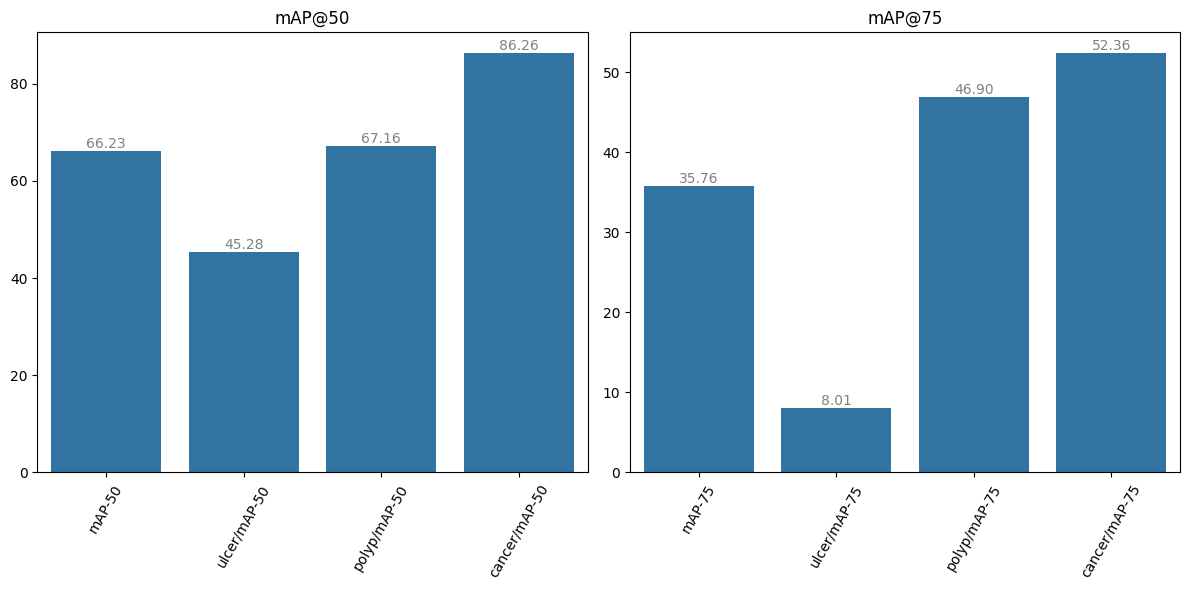

In [27]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.title('mAP@50')
ax = sns.barplot(
    x=['mAP-50', 'ulcer/mAP-50', 'polyp/mAP-50', 'cancer/mAP-50'],
    y = [mean_ap_50*100, average_precisions_50['0'][0]*100,
              average_precisions_50['1'][0]*100, average_precisions_50['2'][0]*100],

)

for rect in ax.patches:
    x = rect.get_x() + rect.get_width() / 2.0  # 막대 중앙 x좌표
    y = rect.get_height()  # 막대 길이
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom', size=10, color='gray')  # 텍스트 위치 조정
plt.xticks(rotation=60)

plt.subplot(1,2,2)
plt.title('mAP@75')
ax = sns.barplot(
    x=['mAP-75', 'ulcer/mAP-75', 'polyp/mAP-75', 'cancer/mAP-75'],
    y = [mean_ap_75*100, average_precisions_75['0'][0]*100,
              average_precisions_75['1'][0]*100, average_precisions_75['2'][0]*100],


)

for rect in ax.patches:
    x = rect.get_x() + rect.get_width() / 2.0  # 막대 중앙 x좌표
    y = rect.get_height()  # 막대 길이
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom', size=10, color='gray')  # 텍스트 위치 조정

plt.xticks(rotation=60)

plt.tight_layout()
plt.show()

## 4. Display Predicted Image
___

In [28]:
def draw_bbox(image, box, label_name, label_id, color):
    alpha_text = 0.8 # text box color
    thickness = 2
    overlay_bbox = image.copy()
    overlay_text = image.copy()
    output = image.copy()

    text_width, text_height = cv2.getTextSize(str(label_id) + ' ' + label_name.upper(), cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)[0]
    # Adding Text Box
    cv2.rectangle(overlay_text, (box[0],box[1]-text_height-5),
                  (box[0]+text_width, box[1]), color, -1)
    cv2.addWeighted(overlay_text, alpha_text, output, 1-alpha_text, 0, output)
    cv2.rectangle(output, (box[0], box[1]), (box[2],box[3]), color, thickness)
    cv2.putText(output, str(label_id) + ' ' + label_name.upper(), (box[0], box[1]-3),
               cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)

    return output

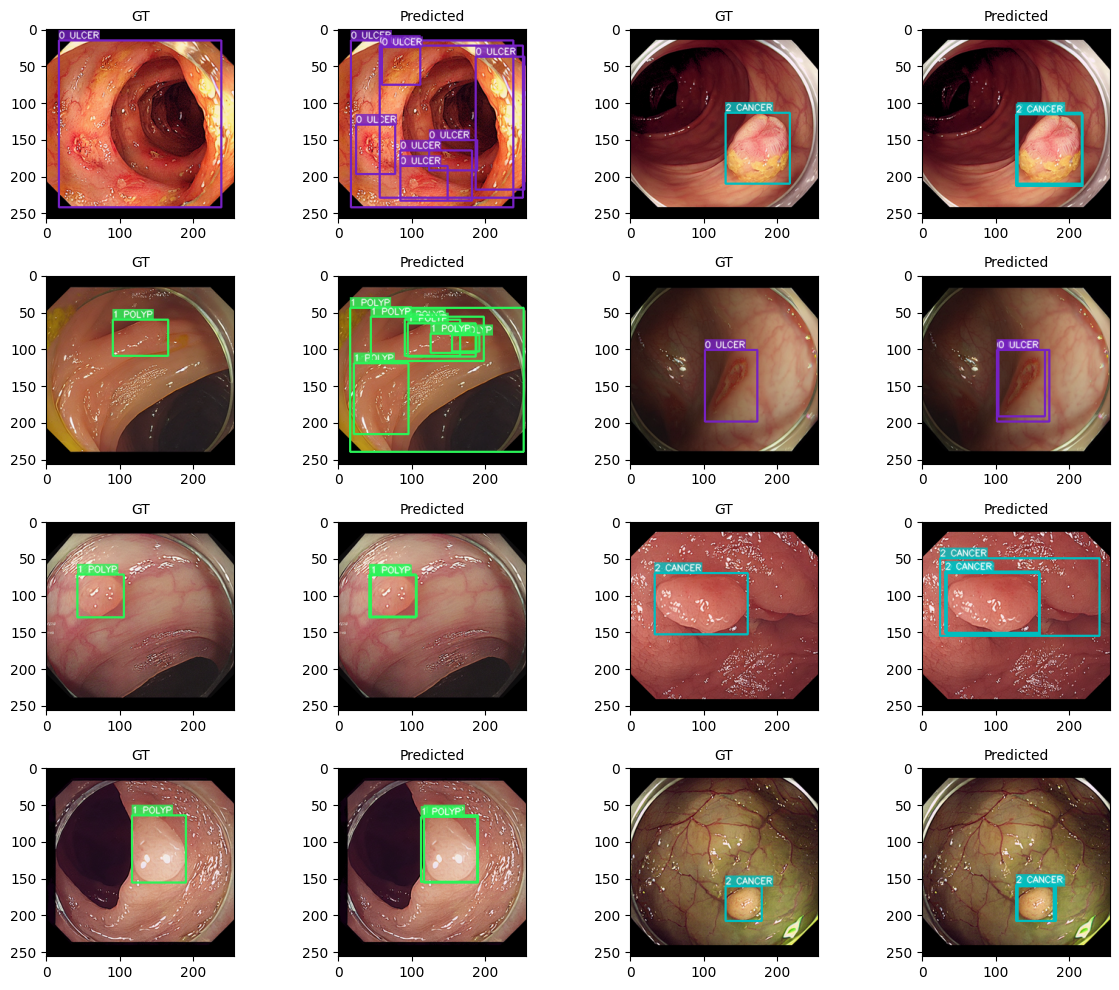

In [29]:
classes = {0: 'Ulcer', 1: 'Polyp', 2: 'Cancer'}
label2color = [[random.randint(0,255) for i in range(3)] for _ in range(CFG.num_classes)]
score_threshold = 0.2

plt.style.use('default')
plt.figure(figsize=(12,10))

for i in range(8):
    j = np.random.randint(0, len(test_dataset), 1)[0]
    image, image_id = test_dataset[j]
    img = image.permute(1,2,0).cpu().numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img*std + mean

    img = (img*255).astype('uint8')
    records = ann[ann['image_id'] == image_id]
    boxes = records[['x_min','y_min','x_max','y_max']].values
    labels = records['lesion_label'].values

    records = det[det['image_id'] == image_id]
    predicted_scores = records['score'].values
    indexes = np.where(predicted_scores >= score_threshold)
    predicted_boxes = records[['x_min','y_min', 'x_max','y_max']].values
    predicted_labels = records['lesion_label'].values
    predicted_boxes = predicted_boxes[indexes]; predicted_labels = predicted_labels[indexes]

    plt.subplot(4,4,2*i+1)
    plt.title('GT', size=10)
    for label_id, box in zip(labels, boxes):
        color = label2color[label_id - 1]
        img = draw_bbox(img, list(np.int_(box)), classes[label_id], label_id, color)
        plt.imshow(img)
        #plt.axis('off')

    plt.subplot(4,4,2*i+2)
    plt.title('Predicted', size=10)
    for label_id, box in zip(predicted_labels, predicted_boxes):
        color = label2color[label_id - 1]
        img = draw_bbox(img, list(np.int_(box)), classes[label_id], label_id, color)
        plt.imshow(img)
        #plt.axis('off')

    clean_memory()
    del image, image_id, records

plt.tight_layout()
plt.show()